In [2]:
import time
import argparse
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from utils import load_citation, sgc_precompute, set_seed, rw_restart_precompute, test_split
from models import get_model
from metrics import accuracy
import pickle as pkl
from args import get_citation_args
from time import perf_counter

# Arguments
args = get_citation_args()
alpha = 0.05
set_seed(args.seed, args.cuda)
adj, features, labels, idx_train, idx_val, idx_test = load_citation(args.dataset, args.normalization, args.cuda, gamma=args.gamma, alpha=alpha)

In [3]:
args.degree = 20
args.normalization = 'RWalkRestart'
args.epochs = 400

In [4]:
args

Namespace(concat=False, cuda=False, dataset='cora', degree=20, dropout=0, epochs=400, experiment='base-experiment', feature='mul', gamma=1.0, hidden=0, lr=0.2, model='SGC', multi_scale=False, multiply_degree=False, no_cuda=False, normalization='RWalkRestart', per=-1, seed=42, tuned=False, weight_decay=5e-06)

In [17]:
args.normalization = 'RWalkRestart'
args.epochs = 400
args.dataset = 'cora'
adj, features, labels, idx_train, idx_val, idx_test = load_citation(args.dataset, args.normalization, args.cuda, gamma=args.gamma, alpha=alpha)
from citation import train_regression, test_regression
print('args.degree is {}'.format(args.degree))
cora_results = []
for degree in np.arange(5,31,5):
    args.degree = degree
    print('------------args.degree = {}------------'.format(args.degree))
    for alpha in [i/100 for i in range(1,26)]:
        cur_features, precompute_time = rw_restart_precompute(features, adj, args.degree, alpha, args.concat)
        model = get_model(args.model, features.size(1), labels.max().item()+1, args.hidden, args.dropout, args.cuda)

        k_fold = True
        acc_test_list = []
        acc_val_list = []
        train_time_list = []
        if k_fold == True:
            idx_splits = test_split(args.dataset)
            idx_splits.append({'train_idx':idx_train,'val_idx':idx_val, 'test_idx':idx_test})
            for idxs in idx_splits:
                idx_train, idx_val, idx_test = idxs['train_idx'], idxs['val_idx'], idxs['test_idx']
                model = get_model(args.model, features.size(1), labels.max().item() + 1, args.hidden, args.dropout,
                                  args.cuda)
                model, cur_acc_val, cur_train_time = train_regression(model, cur_features[idx_train], labels[idx_train], cur_features[idx_val], labels[idx_val],
                                                              args.epochs, args.weight_decay, args.lr, args.dropout)
                cur_acc_test = test_regression(model, cur_features[idx_test], labels[idx_test])
                acc_test_list.append(cur_acc_test)
                acc_val_list.append(cur_acc_val)
                train_time_list.append(cur_train_time)
            acc_test = np.average(acc_test_list)
            acc_val = np.average(acc_val_list)
            train_time = np.average(train_time_list)
        print('-------alpha = {}-----------'.format(alpha))
        print("Validation Accuracy: {:.4f} Test Accuracy: {:.4f}".format(acc_val, acc_test))
        cora_results.append({'degree':args.degree, 'alpha':alpha,'acc_val':acc_val,'acc_test':acc_test})
        print("Pre-compute time: {:.4f}s, train time: {:.4f}s, total: {:.4f}s".format(precompute_time, train_time, precompute_time+train_time))

with open('results/cora_degree.pkl','wb') as f:
    pkl.dump(cora_results,f)

args.degree is 20
------------args.degree = 5------------
-------alpha = 0.01-----------
Validation Accuracy: 0.8080 Test Accuracy: 0.8103
Pre-compute time: 0.3444s, train time: 0.1834s, total: 0.5279s
-------alpha = 0.02-----------
Validation Accuracy: 0.8082 Test Accuracy: 0.8112
Pre-compute time: 0.4012s, train time: 0.1951s, total: 0.5963s
-------alpha = 0.03-----------
Validation Accuracy: 0.8093 Test Accuracy: 0.8117
Pre-compute time: 0.4152s, train time: 0.2062s, total: 0.6214s
-------alpha = 0.04-----------
Validation Accuracy: 0.8098 Test Accuracy: 0.8120
Pre-compute time: 0.3984s, train time: 0.1915s, total: 0.5899s
-------alpha = 0.05-----------
Validation Accuracy: 0.8109 Test Accuracy: 0.8130
Pre-compute time: 0.4386s, train time: 0.1947s, total: 0.6333s
-------alpha = 0.06-----------
Validation Accuracy: 0.8098 Test Accuracy: 0.8128
Pre-compute time: 0.4403s, train time: 0.1973s, total: 0.6376s
-------alpha = 0.07-----------
Validation Accuracy: 0.8104 Test Accuracy: 0.81

-------alpha = 0.07-----------
Validation Accuracy: 0.8151 Test Accuracy: 0.8189
Pre-compute time: 1.0389s, train time: 0.1950s, total: 1.2339s
-------alpha = 0.08-----------
Validation Accuracy: 0.8144 Test Accuracy: 0.8183
Pre-compute time: 1.0951s, train time: 0.1940s, total: 1.2890s
-------alpha = 0.09-----------
Validation Accuracy: 0.8136 Test Accuracy: 0.8161
Pre-compute time: 1.0341s, train time: 0.1979s, total: 1.2321s
-------alpha = 0.1-----------
Validation Accuracy: 0.8142 Test Accuracy: 0.8161
Pre-compute time: 1.0957s, train time: 0.2020s, total: 1.2977s
-------alpha = 0.11-----------
Validation Accuracy: 0.8142 Test Accuracy: 0.8155
Pre-compute time: 1.0992s, train time: 0.2026s, total: 1.3018s
-------alpha = 0.12-----------
Validation Accuracy: 0.8127 Test Accuracy: 0.8139
Pre-compute time: 1.1844s, train time: 0.1771s, total: 1.3615s
-------alpha = 0.13-----------
Validation Accuracy: 0.8104 Test Accuracy: 0.8127
Pre-compute time: 1.1374s, train time: 0.2061s, total: 1

-------alpha = 0.14-----------
Validation Accuracy: 0.8089 Test Accuracy: 0.8119
Pre-compute time: 1.6739s, train time: 0.1962s, total: 1.8702s
-------alpha = 0.15-----------
Validation Accuracy: 0.8093 Test Accuracy: 0.8097
Pre-compute time: 1.7180s, train time: 0.2010s, total: 1.9190s
-------alpha = 0.16-----------
Validation Accuracy: 0.8069 Test Accuracy: 0.8079
Pre-compute time: 1.6730s, train time: 0.1719s, total: 1.8449s
-------alpha = 0.17-----------
Validation Accuracy: 0.8049 Test Accuracy: 0.8061
Pre-compute time: 1.6688s, train time: 0.1723s, total: 1.8410s
-------alpha = 0.18-----------
Validation Accuracy: 0.8042 Test Accuracy: 0.8036
Pre-compute time: 1.6703s, train time: 0.1943s, total: 1.8646s
-------alpha = 0.19-----------
Validation Accuracy: 0.8031 Test Accuracy: 0.8019
Pre-compute time: 1.6746s, train time: 0.1952s, total: 1.8698s
-------alpha = 0.2-----------
Validation Accuracy: 0.8016 Test Accuracy: 0.8004
Pre-compute time: 1.7178s, train time: 0.1978s, total: 1

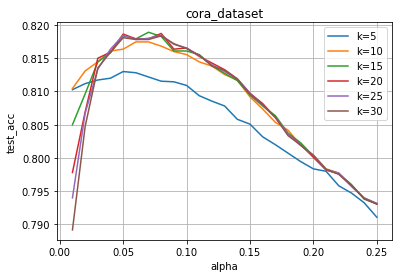

In [18]:
# Provide a figure 
import matplotlib
import matplotlib.pyplot as plt
alpha_list = [i/100 for i in range(1,26)]
k_acc_test = {}
for record in cora_results:
    k = record['degree']
    if k not in k_acc_test.keys():
        k_acc_test[k] = [] 
    k_acc_test[k].append(record['acc_test'])

for k in k_acc_test.keys():
    plt.plot(alpha_list, k_acc_test[k],label='k={}'.format(k))
# plt.plot(alpha_list, AugNormAdj_test_acc_list,label='AugNormAdj')
plt.title('cora_dataset')
plt.xlabel('alpha')
plt.ylabel('test_acc')
plt.grid()
plt.legend()

# fig.savefig("test.png")
plt.show()

In [19]:
args.normalization = 'RWalkRestart'
args.epochs = 400
args.dataset = 'citeseer'
adj, features, labels, idx_train, idx_val, idx_test = load_citation(args.dataset, args.normalization, args.cuda, gamma=args.gamma, alpha=alpha)
from citation import train_regression, test_regression
print('args.degree is {}'.format(args.degree))
citeseer_results = []
for degree in np.arange(10,36,5):
    args.degree = degree
    print('------------args.degree = {}------------'.format(args.degree))
    for alpha in [i/100 for i in range(1,26)]:
    # for alpha in [0.05]:
        cur_features, precompute_time = rw_restart_precompute(features, adj, args.degree, alpha, args.concat)
        model = get_model(args.model, features.size(1), labels.max().item()+1, args.hidden, args.dropout, args.cuda)

        k_fold = True
        acc_test_list = []
        acc_val_list = []
        train_time_list = []
        if k_fold == True:
            idx_splits = test_split(args.dataset)
            idx_splits.append({'train_idx':idx_train,'val_idx':idx_val, 'test_idx':idx_test})
            for idxs in idx_splits:
                idx_train, idx_val, idx_test = idxs['train_idx'], idxs['val_idx'], idxs['test_idx']
                model = get_model(args.model, features.size(1), labels.max().item() + 1, args.hidden, args.dropout,
                                  args.cuda)
                model, cur_acc_val, cur_train_time = train_regression(model, cur_features[idx_train], labels[idx_train], cur_features[idx_val], labels[idx_val],
                                                              args.epochs, args.weight_decay, args.lr, args.dropout)
                cur_acc_test = test_regression(model, cur_features[idx_test], labels[idx_test])
                acc_test_list.append(cur_acc_test)
                acc_val_list.append(cur_acc_val)
                train_time_list.append(cur_train_time)
            acc_test = np.average(acc_test_list)
            acc_val = np.average(acc_val_list)
            train_time = np.average(train_time_list)
        print('-------alpha = {}-----------'.format(alpha))
        print("Validation Accuracy: {:.4f} Test Accuracy: {:.4f}".format(acc_val, acc_test))
        citeseer_results.append({'degree':args.degree, 'alpha':alpha,'acc_val':acc_val,'acc_test':acc_test})
        print("Pre-compute time: {:.4f}s, train time: {:.4f}s, total: {:.4f}s".format(precompute_time, train_time, precompute_time+train_time))
        
    
with open('results/citeseer_degree.pkl','wb') as f:
    pkl.dump(citeseer_results,f)


/home/liujc/Research/Graph_Embedding/SGC/normalization.py:110: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


args.degree is 30
------------args.degree = 10------------
-------alpha = 0.01-----------
Validation Accuracy: 0.6880 Test Accuracy: 0.6942
Pre-compute time: 1.9462s, train time: 0.2335s, total: 2.1798s
-------alpha = 0.02-----------
Validation Accuracy: 0.6902 Test Accuracy: 0.6938
Pre-compute time: 1.9999s, train time: 0.2237s, total: 2.2236s
-------alpha = 0.03-----------
Validation Accuracy: 0.6920 Test Accuracy: 0.6938
Pre-compute time: 1.9944s, train time: 0.2248s, total: 2.2192s
-------alpha = 0.04-----------
Validation Accuracy: 0.6915 Test Accuracy: 0.6949
Pre-compute time: 1.9902s, train time: 0.2244s, total: 2.2146s
-------alpha = 0.05-----------
Validation Accuracy: 0.6911 Test Accuracy: 0.6956
Pre-compute time: 2.0132s, train time: 0.2333s, total: 2.2464s
-------alpha = 0.06-----------
Validation Accuracy: 0.6911 Test Accuracy: 0.6946
Pre-compute time: 2.0271s, train time: 0.2319s, total: 2.2590s
-------alpha = 0.07-----------
Validation Accuracy: 0.6918 Test Accuracy: 0.6

-------alpha = 0.07-----------
Validation Accuracy: 0.6947 Test Accuracy: 0.6969
Pre-compute time: 3.7954s, train time: 0.2335s, total: 4.0289s
-------alpha = 0.08-----------
Validation Accuracy: 0.6955 Test Accuracy: 0.6965
Pre-compute time: 3.8081s, train time: 0.2331s, total: 4.0412s
-------alpha = 0.09-----------
Validation Accuracy: 0.6956 Test Accuracy: 0.6969
Pre-compute time: 3.8065s, train time: 0.2354s, total: 4.0419s
-------alpha = 0.1-----------
Validation Accuracy: 0.6955 Test Accuracy: 0.6986
Pre-compute time: 3.8130s, train time: 0.2313s, total: 4.0443s
-------alpha = 0.11-----------
Validation Accuracy: 0.6962 Test Accuracy: 0.6988
Pre-compute time: 3.8366s, train time: 0.1974s, total: 4.0340s
-------alpha = 0.12-----------
Validation Accuracy: 0.6956 Test Accuracy: 0.6982
Pre-compute time: 3.7752s, train time: 0.2006s, total: 3.9757s
-------alpha = 0.13-----------
Validation Accuracy: 0.6971 Test Accuracy: 0.6984
Pre-compute time: 3.7832s, train time: 0.1962s, total: 3

-------alpha = 0.14-----------
Validation Accuracy: 0.6956 Test Accuracy: 0.6982
Pre-compute time: 5.6095s, train time: 0.2323s, total: 5.8417s
-------alpha = 0.15-----------
Validation Accuracy: 0.6960 Test Accuracy: 0.6992
Pre-compute time: 5.6091s, train time: 0.2344s, total: 5.8436s
-------alpha = 0.16-----------
Validation Accuracy: 0.6965 Test Accuracy: 0.6982
Pre-compute time: 5.6286s, train time: 0.2359s, total: 5.8645s
-------alpha = 0.17-----------
Validation Accuracy: 0.6976 Test Accuracy: 0.6973
Pre-compute time: 5.6166s, train time: 0.2344s, total: 5.8510s
-------alpha = 0.18-----------
Validation Accuracy: 0.6965 Test Accuracy: 0.6971
Pre-compute time: 5.6058s, train time: 0.2340s, total: 5.8398s
-------alpha = 0.19-----------
Validation Accuracy: 0.6936 Test Accuracy: 0.6975
Pre-compute time: 5.6065s, train time: 0.2359s, total: 5.8425s
-------alpha = 0.2-----------
Validation Accuracy: 0.6924 Test Accuracy: 0.6970
Pre-compute time: 5.6049s, train time: 0.2323s, total: 5

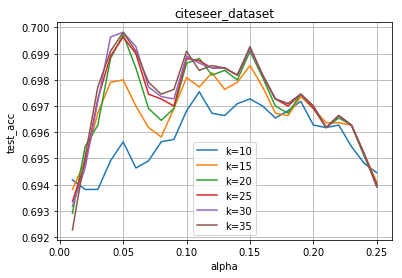

In [20]:
# Provide a figure 
import matplotlib
import matplotlib.pyplot as plt
alpha_list = [i/100 for i in range(1,26)]
k_acc_test = {}
for record in citeseer_results:
    k = record['degree']
    if k not in k_acc_test.keys():
        k_acc_test[k] = [] 
    k_acc_test[k].append(record['acc_test'])

for k in k_acc_test.keys():
    plt.plot(alpha_list, k_acc_test[k],label='k={}'.format(k))
# plt.plot(alpha_list, AugNormAdj_test_acc_list,label='AugNormAdj')
plt.title('citeseer_dataset')
plt.xlabel('alpha')
plt.ylabel('test_acc')
plt.grid()
plt.legend()

# fig.savefig("test.png")
plt.show()

In [21]:
args.normalization = 'RWalkRestart'
args.epochs = 400
args.dataset = 'pubmed'
adj, features, labels, idx_train, idx_val, idx_test = load_citation(args.dataset, args.normalization, args.cuda, gamma=args.gamma, alpha=alpha)
from citation import train_regression, test_regression
print('args.degree is {}'.format(args.degree))
pubmed_results = []
for degree in np.arange(10,36,5):
    args.degree = degree
    print('------------args.degree = {}------------'.format(args.degree))
    for alpha in [i/100 for i in range(1,26)]:
    # for alpha in [0.05]:
        cur_features, precompute_time = rw_restart_precompute(features, adj, args.degree, alpha, args.concat)
        model = get_model(args.model, features.size(1), labels.max().item()+1, args.hidden, args.dropout, args.cuda)

        k_fold = True
        acc_test_list = []
        acc_val_list = []
        train_time_list = []
        if k_fold == True:
            idx_splits = test_split(args.dataset)
            idx_splits.append({'train_idx':idx_train,'val_idx':idx_val, 'test_idx':idx_test})
            for idxs in idx_splits:
                idx_train, idx_val, idx_test = idxs['train_idx'], idxs['val_idx'], idxs['test_idx']
                model = get_model(args.model, features.size(1), labels.max().item() + 1, args.hidden, args.dropout,
                                  args.cuda)
                model, cur_acc_val, cur_train_time = train_regression(model, cur_features[idx_train], labels[idx_train], cur_features[idx_val], labels[idx_val],
                                                              args.epochs, args.weight_decay, args.lr, args.dropout)
                cur_acc_test = test_regression(model, cur_features[idx_test], labels[idx_test])
                acc_test_list.append(cur_acc_test)
                acc_val_list.append(cur_acc_val)
                train_time_list.append(cur_train_time)
            acc_test = np.average(acc_test_list)
            acc_val = np.average(acc_val_list)
            train_time = np.average(train_time_list)
        print('-------alpha = {}-----------'.format(alpha))
        print("Validation Accuracy: {:.4f} Test Accuracy: {:.4f}".format(acc_val, acc_test))
        pubmed_results.append({'degree':args.degree, 'alpha':alpha,'acc_val':acc_val,'acc_test':acc_test})
        print("Pre-compute time: {:.4f}s, train time: {:.4f}s, total: {:.4f}s".format(precompute_time, train_time, precompute_time+train_time))
        
    
with open('results/pubmed_degree.pkl','wb') as f:
    pkl.dump(pubmed_results,f)


args.degree is 35
------------args.degree = 10------------
-------alpha = 0.01-----------
Validation Accuracy: 0.7920 Test Accuracy: 0.7773
Pre-compute time: 82.0435s, train time: 0.1594s, total: 82.2029s
-------alpha = 0.02-----------
Validation Accuracy: 0.7916 Test Accuracy: 0.7792
Pre-compute time: 22.5885s, train time: 0.1410s, total: 22.7295s
-------alpha = 0.03-----------
Validation Accuracy: 0.7929 Test Accuracy: 0.7826
Pre-compute time: 22.5305s, train time: 0.1102s, total: 22.6407s
-------alpha = 0.04-----------
Validation Accuracy: 0.7938 Test Accuracy: 0.7830
Pre-compute time: 22.5499s, train time: 0.1113s, total: 22.6613s
-------alpha = 0.05-----------
Validation Accuracy: 0.7940 Test Accuracy: 0.7837
Pre-compute time: 22.5457s, train time: 0.1003s, total: 22.6460s
-------alpha = 0.06-----------
Validation Accuracy: 0.7944 Test Accuracy: 0.7832
Pre-compute time: 22.4886s, train time: 0.1028s, total: 22.5914s
-------alpha = 0.07-----------
Validation Accuracy: 0.7944 Test A

-------alpha = 0.07-----------
Validation Accuracy: 0.7975 Test Accuracy: 0.7851
Pre-compute time: 44.0835s, train time: 0.1050s, total: 44.1885s
-------alpha = 0.08-----------
Validation Accuracy: 0.7956 Test Accuracy: 0.7856
Pre-compute time: 44.0754s, train time: 0.1096s, total: 44.1850s
-------alpha = 0.09-----------
Validation Accuracy: 0.7925 Test Accuracy: 0.7843
Pre-compute time: 44.1957s, train time: 0.1016s, total: 44.2973s
-------alpha = 0.1-----------
Validation Accuracy: 0.7933 Test Accuracy: 0.7830
Pre-compute time: 44.0893s, train time: 0.1039s, total: 44.1932s
-------alpha = 0.11-----------
Validation Accuracy: 0.7933 Test Accuracy: 0.7821
Pre-compute time: 44.1246s, train time: 0.1068s, total: 44.2313s
-------alpha = 0.12-----------
Validation Accuracy: 0.7933 Test Accuracy: 0.7812
Pre-compute time: 44.1158s, train time: 0.1066s, total: 44.2224s
-------alpha = 0.13-----------
Validation Accuracy: 0.7916 Test Accuracy: 0.7809
Pre-compute time: 44.0616s, train time: 0.10

-------alpha = 0.13-----------
Validation Accuracy: 0.7918 Test Accuracy: 0.7810
Pre-compute time: 65.7598s, train time: 0.1041s, total: 65.8639s
-------alpha = 0.14-----------
Validation Accuracy: 0.7907 Test Accuracy: 0.7805
Pre-compute time: 65.7829s, train time: 0.1082s, total: 65.8911s
-------alpha = 0.15-----------
Validation Accuracy: 0.7889 Test Accuracy: 0.7785
Pre-compute time: 65.8321s, train time: 0.1030s, total: 65.9351s
-------alpha = 0.16-----------
Validation Accuracy: 0.7865 Test Accuracy: 0.7780
Pre-compute time: 65.7977s, train time: 0.1102s, total: 65.9080s
-------alpha = 0.17-----------
Validation Accuracy: 0.7844 Test Accuracy: 0.7767
Pre-compute time: 67.6102s, train time: 0.1039s, total: 67.7141s
-------alpha = 0.18-----------
Validation Accuracy: 0.7835 Test Accuracy: 0.7745
Pre-compute time: 66.0797s, train time: 0.1143s, total: 66.1939s
-------alpha = 0.19-----------
Validation Accuracy: 0.7827 Test Accuracy: 0.7745
Pre-compute time: 67.2937s, train time: 0.1

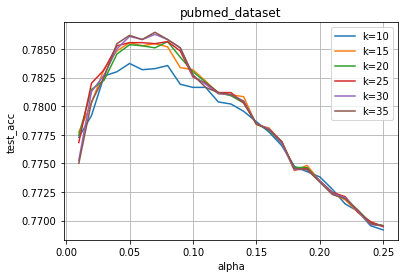

In [22]:
# Provide a figure 
import matplotlib
import matplotlib.pyplot as plt
alpha_list = [i/100 for i in range(1,26)]
k_acc_test = {}
for record in pubmed_results:
    k = record['degree']
    if k not in k_acc_test.keys():
        k_acc_test[k] = [] 
    k_acc_test[k].append(record['acc_test'])

for k in k_acc_test.keys():
    plt.plot(alpha_list, k_acc_test[k],label='k={}'.format(k))
# plt.plot(alpha_list, AugNormAdj_test_acc_list,label='AugNormAdj')
plt.title('pubmed_dataset')
plt.xlabel('alpha')
plt.ylabel('test_acc')
plt.grid()
plt.legend()

# fig.savefig("test.png")
plt.show()

In [30]:
alpha = 0.05
features, precompute_time = rw_restart_precompute(features, adj, args.degree, alpha, args.concat)

print("{:.4f}s".format(precompute_time))

model = get_model(args.model, features.size(1), labels.max().item()+1, args.hidden, args.dropout, args.cuda)

def train_regression(model,
                     train_features, train_labels,
                     val_features, val_labels,
                     epochs=args.epochs, weight_decay=args.weight_decay,
                     lr=args.lr, dropout=args.dropout):

    optimizer = optim.Adam(model.parameters(), lr=lr,
                           weight_decay=weight_decay)
    t = perf_counter()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        if args.model == 'SGC':
            output = model(train_features)
        # if args.model == 'GCN':
        #     output = model(adj, train_features)
        loss_train = F.cross_entropy(output, train_labels)
        loss_train.backward()
        optimizer.step()
    train_time = perf_counter()-t

    with torch.no_grad():
        model.eval()
        output = model(val_features)
        acc_val = accuracy(output, val_labels)

    return model, acc_val, train_time

def test_regression(model, test_features, test_labels):
    model.eval()
    return accuracy(model(test_features), test_labels)

if args.model == "SGC":
    k_fold = True
    acc_test_list = []
    acc_val_list = []
    train_time_list = []
    if k_fold == True:
        idx_splits = test_split(args.dataset)
        idx_splits.append({'train_idx':idx_train,'val_idx':idx_val, 'test_idx':idx_test})
        for idxs in idx_splits:
            idx_train, idx_val, idx_test = idxs['train_idx'], idxs['val_idx'], idxs['test_idx']
            model = get_model(args.model, features.size(1), labels.max().item() + 1, args.hidden, args.dropout,
                              args.cuda)
            model, cur_acc_val, cur_train_time = train_regression(model, features[idx_train], labels[idx_train], features[idx_val], labels[idx_val],
                                                          args.epochs, args.weight_decay, args.lr, args.dropout)
            cur_acc_test = test_regression(model, features[idx_test], labels[idx_test])
            acc_test_list.append(cur_acc_test)
            acc_val_list.append(cur_acc_val)
            train_time_list.append(cur_train_time)
        acc_test = np.average(acc_test_list)
        acc_val = np.average(acc_val_list)
        train_time = np.average(train_time_list)
    else:
        model, acc_val, train_time = train_regression(model, features[idx_train], labels[idx_train], features[idx_val], labels[idx_val],
                                                      args.epochs, args.weight_decay, args.lr, args.dropout)
        acc_test = test_regression(model, features[idx_test], labels[idx_test])

if args.model == "GCN":
    model, acc_val, train_time = train_regression(model, features[idx_train], labels[idx_train], features[idx_val], labels[idx_val],
                                                  args.epochs, args.weight_decay, args.lr, args.dropout)
    acc_test = test_regression(model, features[idx_test], labels[idx_test])

print("Validation Accuracy: {:.4f} Test Accuracy: {:.4f}".format(acc_val, acc_test))
print("Pre-compute time: {:.4f}s, train time: {:.4f}s, total: {:.4f}s".format(precompute_time, train_time, precompute_time+train_time))


1.2645s
Validation Accuracy: 0.6180 Test Accuracy: 0.6100
Pre-compute time: 1.2645s, train time: 0.0501s, total: 1.3146s
